In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import random
import magpylib as magpy
import nbimporter
#%run CoilCreator.ipynb

In [3]:
#%matplotlib notebook
#%matplotlib auto

# Permanent magnet design

(barx, bary, barz) = [6.35, 3.175, 50.8] mm
[0. 0. 0. 0.]


/Users/ChristianHaroldNunez/opt/anaconda3/envs/p37/lib/python3.7/site-packages/magpylib/_src/display/traces_utility.py:95: RuntimeWarning: invalid value encountered in true_divide
  nvec = np.array(vec) / norm
/Users/ChristianHaroldNunez/opt/anaconda3/envs/p37/lib/python3.7/site-packages/magpylib/_src/display/traces_utility.py:382: RuntimeWarning: All-NaN slice encountered
  np.nanmin(np.array(t[k], dtype=float)),
/Users/ChristianHaroldNunez/opt/anaconda3/envs/p37/lib/python3.7/site-packages/magpylib/_src/display/traces_utility.py:383: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.array(t[k], dtype=float)),


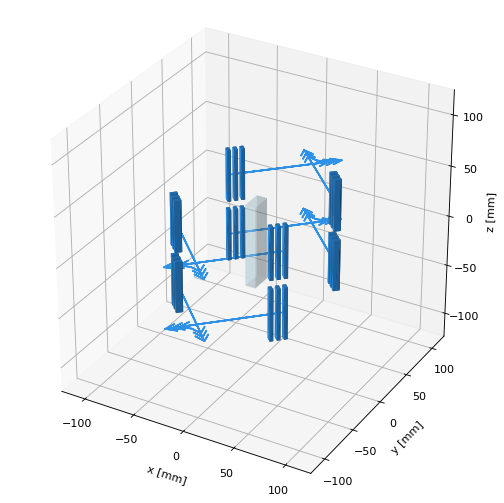

In [4]:
# Better magnet building:

# Magnetization in mT (Remanence field)
## Remanence: Remanence or remanent magnetization or residual magnetism is the magnetization 
## left behind in a ferromagnetic material (such as iron) after an external magnetic field is removed. (Wikipedia)
# Dimension: in mm
# Poisition: in mm
inchtomm = 25.4

barx = (1/4)*inchtomm # mm
bary = (1/8)*inchtomm # mm
barz = 2 * inchtomm # mm

bardims = [barx, bary, barz]
print("(barx, bary, barz) = "+str(bardims)+" mm")

# Neodynmium
rem = 1320 # mT

sidelength = 50 # mm. Half side length
spacer = (1/4)*inchtomm

# Set up magnetic-post configuration
z_centers = [-30, 30]
#z_centers = [0]

# stack
up_stack = 1
down_stack = 1


# Overall collection:
collection = magpy.Collection()
cell_x = 10
cell_y = 20
cell_z = 80
cell = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(cell_x, cell_y, cell_z), style={'color':"lightblue", 'opacity':0.25})
collection.add(cell)

def getDim(tolerances=True):
    if tolerances:
        return (barx +0.2*np.random.random()-0.1, bary+0.2*np.random.random()-0.1, barz+0.2*np.random.random()-0.1)
    else:
        return (barx, bary, barz)

# First make one along the z-axis. 
post = magpy.Collection()
for z in z_centers:
    tol = 0.2*np.random.random()-0.1 # [-0.1, 0.1] mm.
    bar1 = magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=getDim(tolerances=True), position=(0, 0, z))
    post.add(bar1)
    for i in range(0, up_stack):
        bar =  magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=getDim(tolerances=True), position=(0, spacer + i*bary, z))
        post.add(bar)
    for i in range(0, down_stack):
        bar =  magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=getDim(tolerances=True), position=(0,-(spacer + i*bary), z))
        post.add(bar)


# Now with post, make four posts
# Make angular offset array:
#ang_offsets = 2*np.random.rand(4)-1
ang_offsets = np.zeros(4)

post1 = post.copy()
post1.rotate_from_angax(-45+ang_offsets[0], axis='z')
post1.move((-sidelength, sidelength, 0))
collection.add(post1)

post2 = post.copy()
post2.rotate_from_angax(-135+ang_offsets[1], axis='z')
post2.move((-sidelength, -sidelength, 0))
collection.add(post2)

post3 = post.copy()
post3.rotate_from_angax(135+ang_offsets[2], axis='z')
post3.move((sidelength, -sidelength, 0))
collection.add(post3)

post4 = post.copy()
post4.rotate_from_angax(45+ang_offsets[3], axis='z')
post4.move((sidelength, sidelength, 0))
collection.add(post4)

print(ang_offsets)
collection.show()

In [5]:
X = np.linspace(-cell_x/2, cell_x/2, 5)
Y = np.linspace(-cell_y/2, cell_y/2, 5)
Z = np.linspace(-cell_z/2, cell_z/2, 5)

x,y,z = np.meshgrid(X, Y, Z)

collection.getB()


# Generate grid points
xgrid = np.linspace(-scf*x_len/2, scf*x_len/2, int(x_len/grid_spacing))
ygrid = np.linspace(-scf*y_len/2, scf*y_len/2, int(y_len/grid_spacing))
zgrid = np.linspace(-scf*z_len/2, scf*z_len/2, int(z_len/grid_spacing))
gridpoints = (xgrid, ygrid, zgrid) # for interpolation function

# Make data grid:
tree_data = []
array_of_gridpoints = []
for idx, xx in enumerate(xgrid):
    for yy in ygrid:
        for zz in zgrid:
            gridpoint = (xx,yy,zz)
            # Add gridpoint to tree data in array form.
            tree_data.append(np.array([xx,yy,zz]))
            # Add tuple form to array_of_gridpoints. Will be used for .getB, which requires tuples.
            array_of_gridpoints.append((xx,yy,zz))

    # Timing information.
    if (idx+1)%10==0:
        print("Step", idx+1, "/", xgrid.shape[0], "done. | Total time elapsed =", 
              round(time.time()-start_time, 3), "seconds")

array_of_gridpoints = np.array(array_of_gridpoints)

# .getB from the quadcoils:
bfieldtime = time.time()
print("magpylib is calculating B-field on the grid...")
Bfields = magpy.getB(sources=quadcoil, observers=array_of_gridpoints)
print("B-field calculated on the grid in", round((time.time()-bfieldtime)/60, 3), " minutes")

MagpylibBadUserInput: No observers provided
Observers must be either
- array_like positions of shape (N1, N2, ..., 3)
- Sensor object
- Collection with at least one Sensor
- 1D list of the above
received () of type 'tuple' instead.

## Plotting code

In [ ]:
def plot_amp_yz(coil1, x):
    fig, axs = plt.subplots(1, 1, figsize=(13,5))
    
    # create grid
    yts = np.linspace(-10, 10, 40)
    zts = np.linspace(-40, 40, 100)
    grid = np.array([[(x,y,z) for y in yts] for z in zts])
    
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=2) # mT
    
    cp = axs.contourf(
        grid[:,:,1], grid[:,:,2], Bamp * 10,
        levels=100,
        cmap='coolwarm',
    )
    axs.set(
        title='Magnetic Field Amplitude, x = '+str(x),
        xlabel='y-position [mm]',
        ylabel='z-position [mm]',
        aspect=1,
    )
    plt.colorbar(cp, ax=axs, label='G')
    plt.tight_layout()
    plt.show()

plot_amp_yz(collection, x=0)

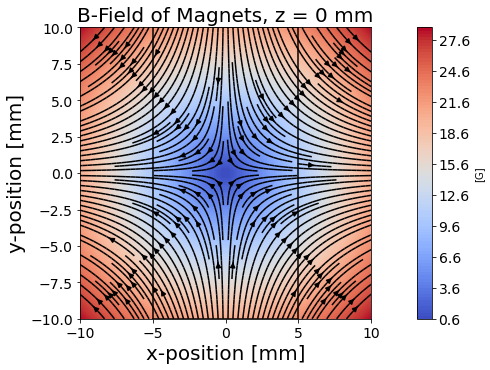

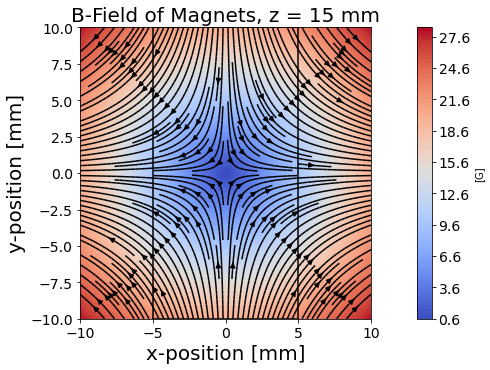

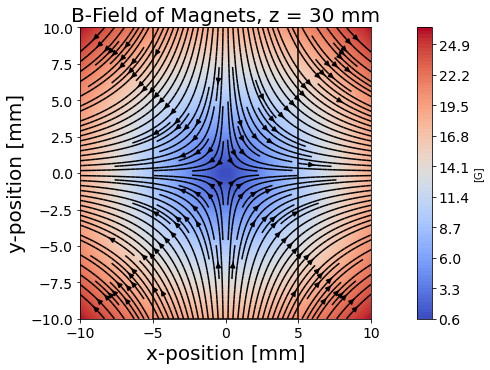

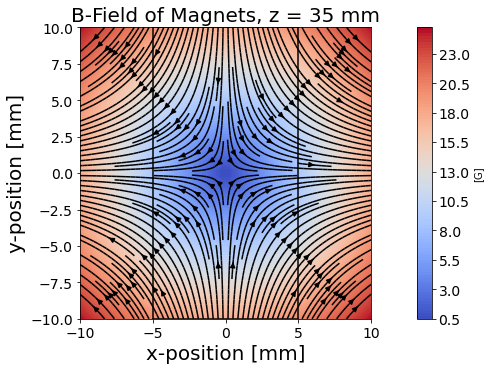

In [29]:
cell_x = 10 #mm
cell_y = 20 #mm
cell_z = 80 #mm
def plot_mag_field_xy(coil1, z=0):
    fig, axs = plt.subplots(1, 1, figsize=(13,5))
    
    # create grid
    yts = np.linspace(-1*cell_y/2, 1*cell_y/2, 40)
    xts = np.linspace(-1*cell_y/2, 1*cell_y/2, 40)
    grid = np.array([[(x,y,z) for x in xts] for y in yts])
    
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=2) * 10
    
    cp = axs.contourf(
        grid[:,:,0], grid[:,:,1], Bamp,
        levels=100,
        cmap='coolwarm',
    )
    axs.streamplot(
        grid[:,:,0], grid[:,:,1], B[:,:,0], B[:,:,1],
        density=2,
        color='black',
    )
    axs.set(
        title='Magnetic field of coil, z = '+str(z)+" mm",
        xlabel='x-position [mm]',
        ylabel='y-position [mm]',
        aspect=1,
    )
    cb = plt.colorbar(cp, ax=axs, label='[G]')
    cb.ax.tick_params(labelsize=14)


    plt.tight_layout()
    
    plt.xlabel("x-position [mm]", fontsize=20)
    plt.ylabel("y-position [mm]", fontsize=20)
    plt.title('B-Field of Magnets, z = '+str(z)+" mm", fontsize=20)
    
    
    # Plotting cell on heatmap:
    plt.plot([-cell_x/2, cell_x/2], [cell_y/2, cell_y/2], '-k')
    plt.plot([-cell_x/2, cell_x/2], [-cell_y/2, -cell_y/2], '-k')
    plt.plot([cell_x/2, cell_x/2], [cell_y/2, -cell_y/2], '-k')
    plt.plot([-cell_x/2, -cell_x/2], [cell_y/2, -cell_y/2], '-k')
    
    axs.tick_params('both', labelsize=14)
    
    
    
    plt.show()

plot_mag_field_xy(collection,z=0)
plot_mag_field_xy(collection,z=15)
plot_mag_field_xy(collection,z=30)
plot_mag_field_xy(collection,z=35)

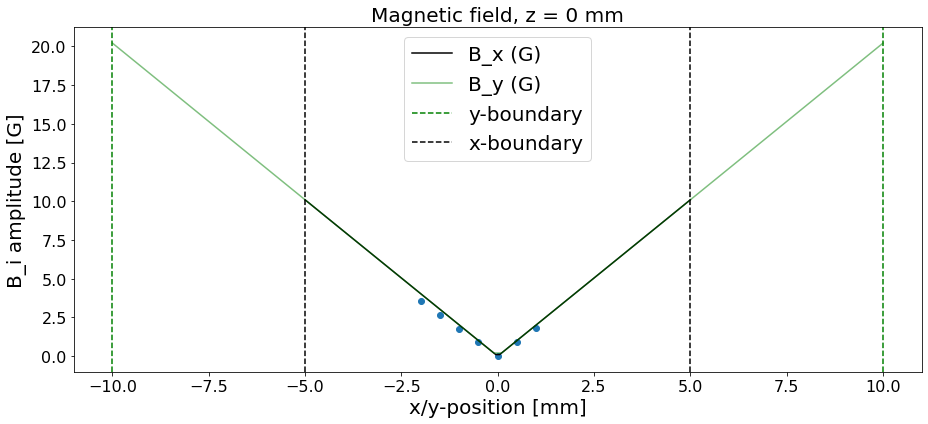

In [6]:
def plot_mag_amp_line(coil1,z):
    fig, ax = plt.subplots(1, 1, figsize=(13,6))
    xts = np.linspace(-cell_x/2, cell_x/2, 100)
    grid = np.array([(x,0,z) for x in xts])
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=1) * 10 # in Gauss
    ax.plot(grid[:,0],Bamp, label="B_x (G)", c="k")
    ax.set_title('Magnetic field, z = '+str(z)+" mm", fontsize=20)
    ax.set_xlabel('x/y-position [mm]', fontsize=20)
    ax.set_ylabel('B_i amplitude [G]', fontsize=20)
    ax.tick_params('both', labelsize=16)
    
    yts = np.linspace(-cell_y/2, cell_y/2, 100)
    grid = np.array([(0,y,z) for y in yts])
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=1) * 10 # in Gauss
    ax.plot(grid[:,1],Bamp, label="B_y (G)", c="g", ls="-", alpha=0.5)

    
    plt.axvline(-cell_y/2, label="y-boundary", c="g", ls="--")
    plt.axvline(cell_y/2, c="g", ls="--")
    
    plt.axvline(-cell_x/2, label="x-boundary", c="k", ls="--")
    plt.axvline(cell_x/2, c="k", ls="--")
    
    plt.tight_layout()
    plt.legend(fontsize=20)
   
    
plot_mag_amp_line(collection, z=0)


# DataCollection 1/11/22
# Trial 1:
#x = [-1, -.5, 0, .5, 1]
#B = (1/1000) * np.array([1788.06, 894.66, 2.00, 899.9, 1791])

# Trial 2: w/ Zeroing
x = [-2, -1.5, -1, -.5, 0, .5, 1] # 2, 2.5, 3, 3.5, 4, 4.5, 5.0] 
B = (1/1000) * np.array([1782.45+1794.88, 1782.45+902.33, 1782.45, 889.7, 1.55, 905.71, 1799.57])
plt.scatter(x, B)
plt.show()


In [9]:
def plot_x_amp(coil1,z):
    fig, axs = plt.subplots(1, 1, figsize=(13,5))
    ts = np.linspace(-5, 5, 40)
    grid = np.array([(x,0,z) for x in ts])
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=1) * 10 # in Gauss
    axs.plot(grid[:,0],Bamp)
    axs.set(
        title='Magnetic field of coil',
        xlabel='x-position [mm]',
        ylabel='B_x amplitude [G]',
    )
    plt.tight_layout()
    plt.show()
    
def plot_y_amp(coil1,z):
    fig, axs = plt.subplots(1, 1, figsize=(13,5))
    ts = np.linspace(-10, 10, 40)
    grid = np.array([(0,y,z) for y in ts])
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=1) * 10 # in Gauss
    axs.plot(grid[:,1],Bamp)
    axs.set(
        title='Magnetic field of coil',
        xlabel='y-position [mm]',
        ylabel='B_y amplitude [G]',
    )
    plt.tight_layout()
    plt.show()
    
#plot_x_amp(collection, 0)
#plot_x_amp(collection, 10)
#plot_x_amp(collection, 20)
#plot_x_amp(collection, 30)
#plot_y_amp(collection, 0)

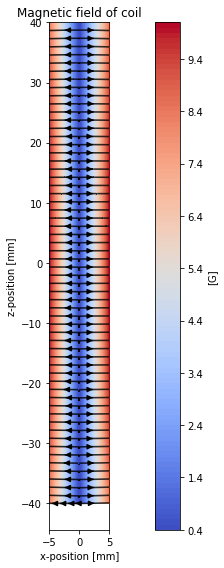

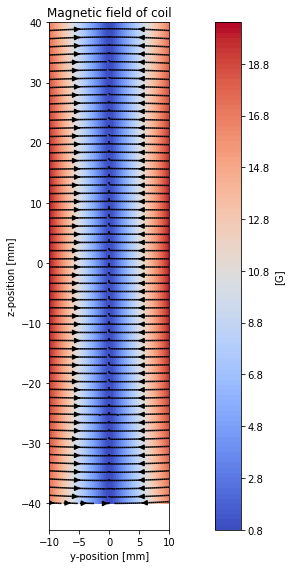

In [8]:
def plot_mag_field_xz(coil1, y=0):
    fig, axs = plt.subplots(1, 1, figsize=(13,8))
    
    # create grid
    ts = np.linspace(-5, 5, 20)
    zts = np.linspace(-40, 40, 100)
    grid = np.array([[(x,y,z) for x in ts] for z in zts])
    
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=2) * 10
    
    cp = axs.contourf(
        grid[:,:,0], grid[:,:,2], Bamp,
        levels=100,
        cmap='coolwarm',
    )
    axs.streamplot(
        grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2],
        density=2,
        color='black',
    )
    axs.set(
        title='Magnetic field of coil',
        xlabel='x-position [mm]',
        ylabel='z-position [mm]',
        aspect=1,
    )
    plt.colorbar(cp, ax=axs, label='[G]')
    plt.tight_layout()
    plt.show()
    
def plot_mag_field_yz(coil1, x=0):
    fig, axs = plt.subplots(1, 1, figsize=(13,8))
    
    # create grid
    ts = np.linspace(-10, 10, 20)
    zts = np.linspace(-40, 40, 100)
    grid = np.array([[(x,y,z) for y in ts] for z in zts])
    
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=2) * 10
    
    cp = axs.contourf(
        grid[:,:,1], grid[:,:,2], Bamp,
        levels=100,
        cmap='coolwarm',
    )
    axs.streamplot(
        grid[:,:,1], grid[:,:,2], B[:,:,1], B[:,:,2],
        density=2,
        color='black',
    )
    axs.set(
        title='Magnetic field of coil',
        xlabel='y-position [mm]',
        ylabel='z-position [mm]',
        aspect=1,
    )
    plt.colorbar(cp, ax=axs, label='[G]')
    plt.tight_layout()
    plt.show()

plot_mag_field_xz(collection, y=0)
plot_mag_field_yz(collection, x=0)

## Old design idea

In [ ]:
# Magnetization in mT (Remanence field)
## Remanence: Remanence or remanent magnetization or residual magnetism is the magnetization 
## left behind in a ferromagnetic material (such as iron) after an external magnetic field is removed. (Wikipedia)
# Dimension: in mm
# Poisition: in mm
inchtomm = 25.4

barx = (1/4)*inchtomm # mm
bary = (1/16)*inchtomm # mm
barz = 2 * inchtomm # mm
rem = 1300 # mT

sidelength = 50 # mm. Half side length


def buildMagnets(includeCell = False):
    collection = magpy.Collection()
    for z in [-30, 30]:
        cell = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(10, 20, 80), style={'color':"lightblue", 'opacity':0.25})
        collection.add(cell)

        bar1 = magpy.magnet.Cuboid(magnetization=(0,-rem,0), dimension=(barx, bary, barz), position=(sidelength, -sidelength, z))
        bar1.rotate_from_angax(-45, axis='z')
        collection.add(bar1)

        bar2 = magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=(barx, bary, barz), position=(sidelength, sidelength, z))
        bar2.rotate_from_angax(45, axis='z')
        collection.add(bar2)

        bar3 = magpy.magnet.Cuboid(magnetization=(0,-rem,0), dimension=(barx, bary, barz), position=(-sidelength, -sidelength, z))
        bar3.rotate_from_angax(45, axis='z')
        collection.add(bar3)

        bar4 = magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=(barx, bary, barz), position=(-sidelength, sidelength, z))
        bar4.rotate_from_angax(-45, axis='z')
        collection.add(bar4)

    return collection

collection = buildMagnets(includeCell=True)
collection.show()
print(barz)